# Test FST Briefing

A catalog of the **30 FST constructors** in `transduction.examples`,
organized by what makes each one interesting for testing decomposition
algorithms.

`test_general.py` uses 18 of these across **8 algorithm implementations**
(5 Python + 3 Rust). Each test recursively calls `decompose_next()` and
verifies the quotient/remainder pair against the reference `Precover`.
The remaining FSTs are used in `test_finite.py`, `test_push_labels.py`,
or serve as building blocks.

### Implementations in test_general.py

| Implementation | Lang | Incremental | Notes |
|----------------|:----:|:-----------:|-------|
| TruncatedIncrementalDFADecomp | Py | ✓ | Dirty-state + truncation |
| NonrecursiveDFADecomp | Py | | Full recomputation each step |
| PeekabooState | Py | ✓ | Per-symbol Q/R via peekaboo |
| PeekabooNonrecursive | Py | | Non-incremental peekaboo |
| DirtyPeekaboo | Py | ✓ | Dirty-state peekaboo |
| RustDecomp | Rs | | Full powerset decomposition |
| RustDirtyState | Rs | ✓ | Dirty-state incremental |
| RustDirtyPeekaboo | Rs | ✓ | Dirty-state peekaboo |

In [1]:
from transduction import examples, FST, EPSILON, Precover
from transduction.universality import compute_ip_universal_states, check_all_input_universal
from IPython.display import display, Markdown

try:
    from transduction.rust_bridge import to_rust_fst
    import transduction_core
    HAS_RUST = True
except ImportError:
    HAS_RUST = False

def brief(fst, name):
    aiu = check_all_input_universal(fst)
    ip = compute_ip_universal_states(fst)
    is_fun, _ = fst.is_functional()
    n = len(list(fst.states))
    print(f'{name}: {n} states, |A|={len(fst.A - {EPSILON})}, |B|={len(fst.B - {EPSILON})}')
    print(f'  all_input_universal={aiu}, ip_universal={sorted(ip)} ({len(ip)}/{n}), functional={is_fun}')

def rust_stats(fst, target_syms):
    if not HAS_RUST:
        print('  (Rust not available)'); return
    rust_fst, sym_map, _ = to_rust_fst(fst)
    target_u32 = [sym_map(y) for y in target_syms]
    s = transduction_core.rust_decompose(rust_fst, target_u32).stats
    print(f'  DFA: {s.dfa_states} states, {s.total_arcs} arcs')
    print(f'  universality: {s.universal_calls} calls ({s.universal_true} T, {s.universal_false} F), sub_bfs={s.universal_sub_bfs_states}')

## Overview

All 30 example FSTs at a glance.

- **fun**: is a (partial) function (required for peekaboo agreement)
- **aiu**: `check_all_input_universal` (enables universality fast path)
- **ip**: count of ip-universal states / total states
- **tests**: G = `test_general.py`, F = `test_finite.py`, P = `test_push_labels.py`

In [2]:
import pandas as pd

all_fsts = [
    ('replace',              examples.replace([('1','a'),('2','b'),('3','c'),('4','d'),('5','e')])),
    ('delete_b',             examples.delete_b()),
    ('duplicate',            examples.duplicate(set('12345'))),
    ('weird_copy',           examples.weird_copy()),
    ('togglecase',           examples.togglecase()),
    ('lowercase',            examples.lowercase()),
    ('small',                examples.small()),
    ('samuel_example',       examples.samuel_example()),
    ('sdd1_fst',             examples.sdd1_fst()),
    ('lookahead',            examples.lookahead()),
    ('mystery1',             examples.mystery1()),
    ('mystery2',             examples.mystery2()),
    ('mystery3',             examples.mystery3()),
    ('mystery4',             examples.mystery4()),
    ('mystery5',             examples.mystery5()),
    ('mystery6',             examples.mystery6()),
    ('mystery7',             examples.mystery7()),
    ('mystery8',             examples.mystery8()),
    ('newspeak2',            examples.newspeak2()),
    ('number_comma_sep',     examples.number_comma_separator({'a',',', ' ','0'}, Digit={'0'})),
    ('parity',               examples.parity({'a','b'})),
    ('triplets_of_doom',     examples.triplets_of_doom()),
    ('doom(K=4)',            examples.doom({'a','b'}, 4)),
    ('infinite_quotient',    examples.infinite_quotient()),
    ('infinite_quotient2',   examples.infinite_quotient2()),
    ('gated_universal',      examples.gated_universal()),
    ('complementary_halves', examples.complementary_halves()),
    ('shrinking_nonuniv',    examples.shrinking_nonuniversal()),
    ('scaled_newspeak',      examples.scaled_newspeak(n_patterns=3, alpha_size=6)),
    ('layered_witnesses',    examples.layered_witnesses()),
]
fst_of = {name: fst for name, fst in all_fsts}

test_coverage = {
    'replace': 'GF', 'delete_b': 'GFP', 'duplicate': 'GF', 'weird_copy': 'GP',
    'togglecase': '', 'lowercase': '',
    'small': 'GP', 'samuel_example': 'GFP', 'sdd1_fst': 'GF', 'lookahead': 'GP',
    'mystery1': 'P', 'mystery2': '', 'mystery3': 'P', 'mystery4': 'P', 'mystery5': 'P',
    'mystery6': '', 'mystery7': 'P', 'mystery8': 'P',
    'newspeak2': 'GF', 'number_comma_sep': 'GF', 'parity': 'GP',
    'triplets_of_doom': 'G', 'doom(K=4)': '', 'infinite_quotient': 'G', 'infinite_quotient2': '',
    'gated_universal': 'G', 'complementary_halves': 'G', 'shrinking_nonuniv': 'G',
    'scaled_newspeak': 'G', 'layered_witnesses': 'G',
}

rows = []
for name, fst in all_fsts:
    n = len(list(fst.states))
    ip = len(compute_ip_universal_states(fst))
    is_fun, _ = fst.is_functional()
    rows.append({
        'name': name,
        '|Q|': n,
        '|A|': len(fst.A - {EPSILON}),
        '|B|': len(fst.B - {EPSILON}),
        'fun': is_fun,
        'aiu': check_all_input_universal(fst),
        'ip': f'{ip}/{n}',
        '\u03b5-in': EPSILON in fst.A,
        '\u03b5-out': EPSILON in fst.B,
        'tests': test_coverage.get(name, '') or '\u2014',
    })
df = pd.DataFrame(rows).set_index('name')
df

,|Q|,|A|,|B|,fun,aiu,ip,ε-in,ε-out,tests
name,,,,,,,,,
replace,1,5,5,True,True,1/1,False,False,GF
delete_b,1,2,2,True,True,1/1,False,True,GFP
duplicate,6,5,5,True,True,6/6,True,False,GF
weird_copy,3,2,2,True,True,3/3,True,True,GP
togglecase,1,53,53,True,True,1/1,False,False,—
lowercase,1,53,27,True,True,1/1,False,False,—
small,4,2,3,True,False,1/4,False,False,GP
samuel_example,5,2,3,True,False,2/5,True,True,GFP
sdd1_fst,3,2,2,True,False,1/3,True,True,GF


## All-input-universal FSTs

When every FST state is ip-universal (its input projection accepts Σ\*),
the quotient at each decomposition step is Σ\* and the remainder carries
all the constraints. This enables the `all_input_universal` fast path that
skips powerset construction entirely.

Six example FSTs have this property:

- **replace** — symbol-for-symbol substitution (test_abc uses 1→a, 2→b, …)
- **delete_b** — deletes `b`, maps `a→A`. Infinite quotients (`b*` in every quotient).
- **duplicate** — repeats each symbol K times: `abc → aabbcc`
- **weird_copy** — identity with ε-input arcs back to start
- **togglecase** — swaps case: a↔A, b↔B, … (53-symbol alphabet, not tested)
- **lowercase** — maps uppercase to lowercase (53-symbol alphabet, not tested)

replace: 1 states, |A|=5, |B|=5
  all_input_universal=True, ip_universal=[0] (1/1), functional=True


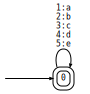


delete_b: 1 states, |A|=2, |B|=2
  all_input_universal=True, ip_universal=[0] (1/1), functional=True


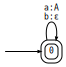


duplicate: 6 states, |A|=5, |B|=5
  all_input_universal=True, ip_universal=[0, 1, 2, 3, 4, 5] (6/6), functional=True


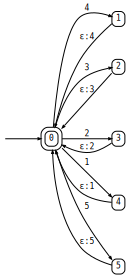


weird_copy: 3 states, |A|=2, |B|=2
  all_input_universal=True, ip_universal=[0, 1, 2] (3/3), functional=True


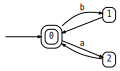


togglecase: 1 states, |A|=53, |B|=53
  all_input_universal=True, ip_universal=[0] (1/1), functional=True


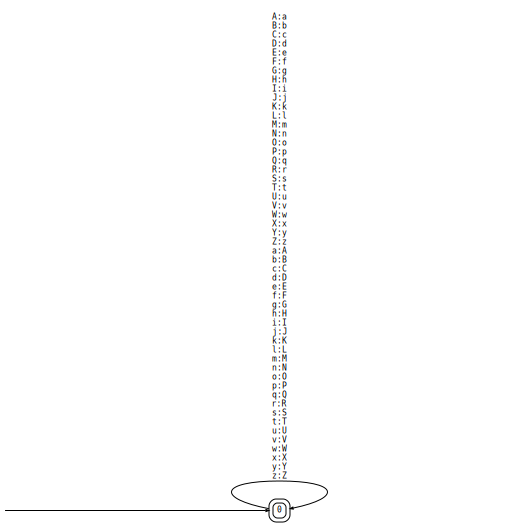


lowercase: 1 states, |A|=53, |B|=27
  all_input_universal=True, ip_universal=[0] (1/1), functional=True


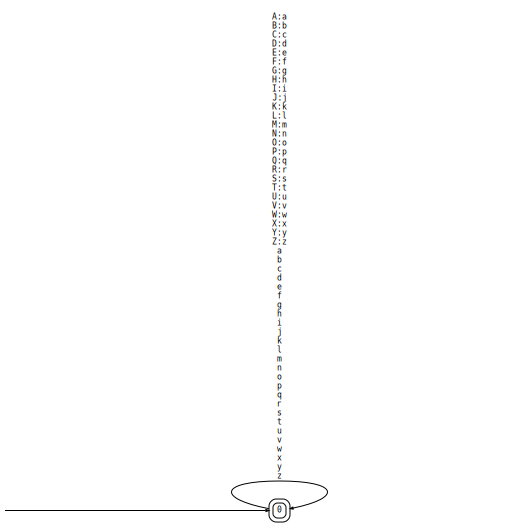

In [3]:
for name in ['replace', 'delete_b', 'duplicate', 'weird_copy', 'togglecase', 'lowercase']:
    brief(fst_of[name], name)
    display(fst_of[name])
    print()

## Epsilon structure

These FSTs use ε-output arcs (emit nothing while consuming input) or
ε-input arcs (emit output without consuming input). The precover NFA
tracks a **target buffer** of pending output symbols. This tests that
the powerset determinization correctly handles buffer accumulation across
nondeterministic branches.

### small, samuel_example, sdd1_fst

Three compact FSTs with different epsilon patterns:
- **small** — branching with one ε-output arc, delayed emission
- **samuel_example** — multiple ε-output arcs creating parallel precover paths
- **sdd1_fst** — ε-input arc creating a parallel start path

small: 4 states, |A|=2, |B|=3
  all_input_universal=False, ip_universal=[3] (1/4), functional=True


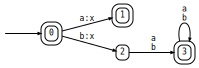


samuel_example: 5 states, |A|=2, |B|=3
  all_input_universal=False, ip_universal=[3, 4] (2/5), functional=True


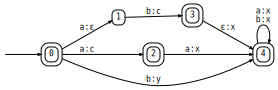


sdd1_fst: 3 states, |A|=2, |B|=2
  all_input_universal=False, ip_universal=[2] (1/3), functional=True


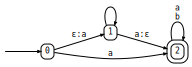

In [4]:
for name in ['small', 'samuel_example', 'sdd1_fst']:
    brief(fst_of[name], name)
    display(fst_of[name])
    print()

### lookahead

The most complex ε-output example. A chain of ε-output arcs creates
precover NFA states with long target buffers — the FST "looks ahead" by
consuming input early and emitting output later.

lookahead: 7 states, |A|=2, |B|=3
  all_input_universal=False, ip_universal=[4] (1/7), functional=True


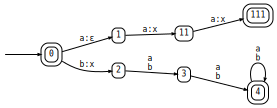

In [5]:
fst = fst_of['lookahead']
brief(fst, 'lookahead')
display(fst)

In [6]:
B = sorted(fst.B - {EPSILON})
P = Precover(fst, tuple(B[:3]))
display(P)
P.show_decomposition()

quotient,remainder
∅,∅


### mystery1, mystery2, mystery7, mystery8

Four FSTs exploring variations of ε-consuming paths. Each offers
multiple routes to the same output — a direct arc vs. one or more
ε-consuming steps followed by emission. Used primarily in
`test_push_labels.py`.

- **mystery1** — two paths to `c`: direct `a→c` or ε-consuming `b→ε` then `a→c`
- **mystery2** — three paths: direct, two-step, and triple-ε
- **mystery7** — two paths to `c` via different state routes, then `x`-loop
- **mystery8** — mixed direct and ε-consuming paths with final accepting state

mystery1: 4 states, |A|=2, |B|=2
  all_input_universal=False, ip_universal=[1, 3] (2/4), functional=True


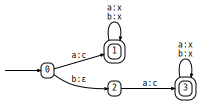


mystery2: 6 states, |A|=2, |B|=2
  all_input_universal=False, ip_universal=[1, 2, 3] (3/6), functional=True


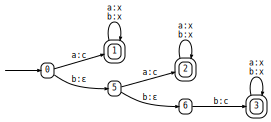


mystery7: 4 states, |A|=2, |B|=2
  all_input_universal=False, ip_universal=[2, 3] (2/4), functional=True


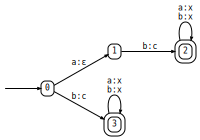


mystery8: 4 states, |A|=2, |B|=2
  all_input_universal=False, ip_universal=[3] (1/4), functional=True


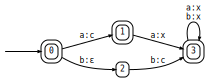

In [7]:
for name in ['mystery1', 'mystery2', 'mystery7', 'mystery8']:
    brief(fst_of[name], name)
    display(fst_of[name])
    print()

### mystery6 — the only non-functional FST

`mystery6` is the **only FST in `examples.py` that is not a function**.
It has two paths that produce *different outputs* for the same input,
making it a genuine relation. This means peekaboo decompositions will
**not** agree with Precover on this FST, which is why it's excluded from
`test_general.py`.

mystery6: 6 states, |A|=3, |B|=3
  all_input_universal=False, ip_universal=[3] (1/6), functional=False


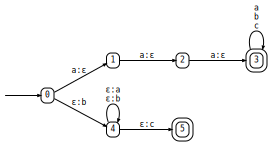

In [8]:
fst = fst_of['mystery6']
brief(fst, 'mystery6')
display(fst)

## Conditional / delayed output

These FSTs consume input without emitting, then produce output at the
end via ε-output arcs. The output depends on a property of the entire
input string (last symbol, count, parity, etc.).

- **parity** — emits `0` or `1` based on even/odd input length
- **mystery3** — emits `A` or `B` depending on whether the last symbol was `a` or `b`
- **mystery4** — emits `1` if exactly one `a` in input, else `0`
- **mystery5** — emits `0`, `1`, or `2` based on input length mod 3

parity: 3 states, |A|=2, |B|=2
  all_input_universal=False, ip_universal=[0, 1] (2/3), functional=True


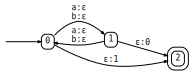


mystery3: 5 states, |A|=2, |B|=2
  all_input_universal=False, ip_universal=[1, 2] (2/5), functional=True


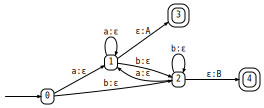


mystery4: 5 states, |A|=2, |B|=2
  all_input_universal=False, ip_universal=[0, 1, 2] (3/5), functional=True


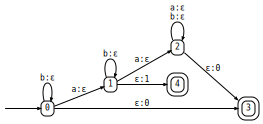


mystery5: 6 states, |A|=2, |B|=3
  all_input_universal=False, ip_universal=[0, 1, 2] (3/6), functional=True


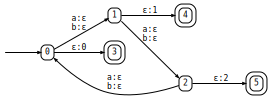

In [9]:
for name in ['parity', 'mystery3', 'mystery4', 'mystery5']:
    brief(fst_of[name], name)
    display(fst_of[name])
    print()

## Application-scale FSTs

Larger alphabets and more states, approaching the complexity of
real-world transducers.

### newspeak2

Replaces `"bad" → "ungood"` over the 26-letter English alphabet.
With 8 states, 85 arcs, and |B|=26, this is the largest hand-coded FST.
Tested at depth 1 (with three starting targets) because the branching
factor is 26.

newspeak2: 8 states, |A|=26, |B|=26
  all_input_universal=False, ip_universal=[] (0/8), functional=True


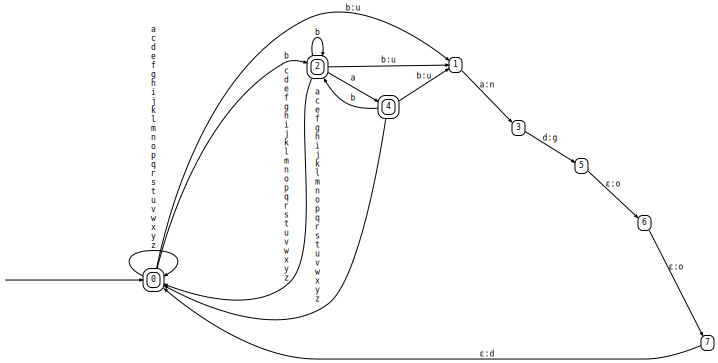

In [10]:
fst = fst_of['newspeak2']
brief(fst, 'newspeak2')
display(fst)

### number_comma_separator

A stateful formatting transducer: inserts `|` separators after commas in
number sequences (`"1, 2, 3" → "1,| 2,| 3"`). The **only test that
exercises non-empty initial targets** — `run_test` is called three times:

1. `target=''` at depth 4 (from root)
2. `target='0,| 0,'` at depth 1 (mid-sequence)
3. `target='0,| 0,|'` at depth 1 (post-separator)

number_comma_separator: 3 states, |A|=4, |B|=5
  all_input_universal=False, ip_universal=[0, 1] (2/3), functional=True


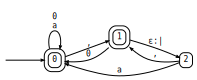

In [11]:
fst = fst_of['number_comma_sep']
brief(fst, 'number_comma_separator')
display(fst)

## Termination stress tests

General-case algorithms must terminate on FSTs with **infinite quotient
and remainder languages**. The key mechanism is **target-buffer truncation**:
when the powerset determinization discovers a universal DFA state (one that
accepts Σ\*), it truncates the precover NFA buffer, bounding the state space.

Algorithms without truncation (`LazyIncremental`, etc.) diverge on these
FSTs — that's why they're excluded from `test_general.py`.

### triplets_of_doom

The quintessential termination test. A copy transducer for `(a³|b³)*`.
Historically significant: the first example that demonstrated the need for
target-buffer truncation. Without it, each arc appends to the buffer and
the powerset DFA construction never terminates.

Tested at **depth 13** — far deeper than any other test.

triplets_of_doom: 5 states, |A|=2, |B|=2
  all_input_universal=False, ip_universal=[] (0/5), functional=True


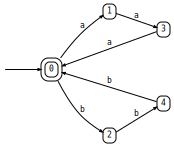

In [12]:
fst = fst_of['triplets_of_doom']
brief(fst, 'triplets_of_doom')
display(fst)

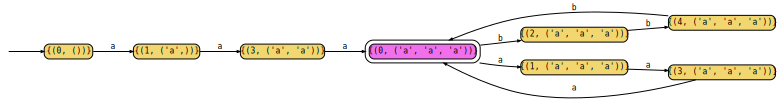


Rust stats at increasing target lengths:
  target_len=3:
  DFA: 8 states, 9 arcs
  universality: 1 calls (0 T, 1 F), sub_bfs=1
  target_len=6:
  DFA: 11 states, 12 arcs
  universality: 1 calls (0 T, 1 F), sub_bfs=1
  target_len=13:
  DFA: 18 states, 19 arcs
  universality: 1 calls (0 T, 1 F), sub_bfs=1


In [13]:
P = Precover(fst, ('a', 'a', 'a'))
display(P)
P.show_decomposition()

if HAS_RUST:
    print('\nRust stats at increasing target lengths:')
    for tlen in [3, 6, 13]:
        print(f'  target_len={tlen}:')
        rust_stats(fst, tuple('a' for _ in range(tlen)))

### doom

The generalization of `triplets_of_doom`: a copy transducer for
`(a^K | b^K)*` parameterized by alphabet V and repeat count K.
`triplets_of_doom()` = `doom({'a','b'}, 3)`. Shown here with K=4.

doom(K=4): 7 states, |A|=2, |B|=2
  all_input_universal=False, ip_universal=[] (0/7), functional=True


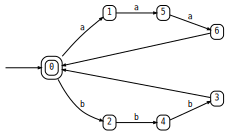

In [14]:
fst = fst_of['doom(K=4)']
brief(fst, 'doom(K=4)')
display(fst)

### infinite_quotient

The FST absorbs unbounded input in one state, then emits a constant.
The quotient language is infinite (strings of all lengths), but the
powerset DFA state is universal, so truncation kicks in immediately.

infinite_quotient: 3 states, |A|=2, |B|=1
  all_input_universal=False, ip_universal=[0, 1] (2/3), functional=True


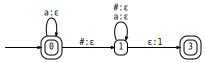

In [15]:
fst = fst_of['infinite_quotient']
brief(fst, 'infinite_quotient')
display(fst)

### infinite_quotient2

Tracks parity of `a` count, absorbs input after `#` separator, and
emits the parity at the end via ε-output. Combines the infinite-quotient
property with conditional output. Not currently in any test file.

infinite_quotient2: 5 states, |A|=3, |B|=2
  all_input_universal=False, ip_universal=[0, 1, 2, 3] (4/5), functional=True


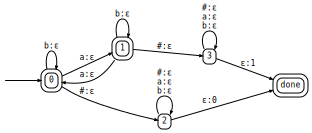

In [16]:
fst = fst_of['infinite_quotient2']
brief(fst, 'infinite_quotient2')
display(fst)

## Universality filter hierarchy

During powerset determinization, the algorithm repeatedly checks whether
a DFA state is **universal** (accepts Σ\*). The `UniversalityFilter`
optimizes this with a 5-level hierarchy:

| Level | Name | Cost | Mechanism |
|-------|------|------|----------|
| 1 | `all_input_universal` fast path | O(1) | Every FST state is ip-universal ⇒ all DFA states universal |
| 2 | ip-universal witness check | O(\|S\|) | Powerset S contains a known ip-universal element |
| 3 | Positive cache (superset mono.) | O(\|S\|) | Cached universal U ⊆ S ⇒ S universal |
| 4 | Negative cache (subset mono.) | O(\|S\|) | S ⊆ cached non-universal ⇒ S non-universal |
| 5 | BFS fallback | O(\|DFA\|) | Full BFS; result cached |

Five FSTs are designed so that a specific level is the *first* one that
resolves universality. All five are **partial functions** (required for
peekaboo agreement).

### gated_universal — *witness check (level 2)*

Non-final gate dispatches to an ip-universal sink and a partial sink.
The powerset always contains the ip-universal witness — universality
resolves without BFS.

gated_universal: 3 states, |A|=3, |B|=1
  all_input_universal=False, ip_universal=[1] (1/3), functional=True


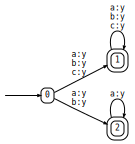


Rust stats:
  target_len=3:
  DFA: 7 states, 15 arcs
  universality: 2 calls (2 T, 0 F), sub_bfs=0
  target_len=5:
  DFA: 11 states, 27 arcs
  universality: 2 calls (2 T, 0 F), sub_bfs=0
  target_len=10:
  DFA: 21 states, 57 arcs
  universality: 2 calls (2 T, 0 F), sub_bfs=0


In [17]:
fst = fst_of['gated_universal']
brief(fst, 'gated_universal')
display(fst)

if HAS_RUST:
    print('\nRust stats:')
    for tlen in [3, 5, 10]:
        print(f'  target_len={tlen}:')
        rust_stats(fst, tuple('y' for _ in range(tlen)))

### complementary_halves — *BFS + positive cache (levels 5, 3)*

Four states over {a,b,c,d}, each covering half the alphabet.
No state is ip-universal. Universality of {1,2,3,4} requires
**BFS fallback**; subsequent queries hit the **positive cache**.

complementary_halves: 5 states, |A|=4, |B|=1
  all_input_universal=False, ip_universal=[] (0/5), functional=True


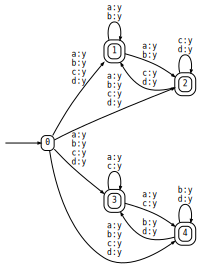


Rust stats:
  target_len=3:
  DFA: 4 states, 12 arcs
  universality: 1 calls (1 T, 0 F), sub_bfs=1
  target_len=5:
  DFA: 6 states, 20 arcs
  universality: 1 calls (1 T, 0 F), sub_bfs=1
  target_len=10:
  DFA: 11 states, 40 arcs
  universality: 1 calls (1 T, 0 F), sub_bfs=1


In [18]:
fst = fst_of['complementary_halves']
brief(fst, 'complementary_halves')
display(fst)

if HAS_RUST:
    print('\nRust stats:')
    for tlen in [3, 5, 10]:
        print(f'  target_len={tlen}:')
        rust_stats(fst, tuple('y' for _ in range(tlen)))

### shrinking_nonuniversal — *negative cache (level 4)*

Three states, none covering `c`. Powerset {1,2,3} is **not universal**.
On subsequent steps the powerset shrinks; subsets are recognized as
non-universal via the **negative cache**.

**No universal states at all**: q_stops=0, every step produces a remainder.

shrinking_nonuniversal: 4 states, |A|=3, |B|=1
  all_input_universal=False, ip_universal=[] (0/4), functional=True


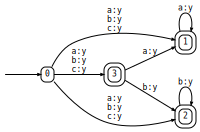


Rust stats:
  target_len=3:
  DFA: 6 states, 9 arcs
  universality: 2 calls (0 T, 2 F), sub_bfs=2
  target_len=5:
  DFA: 10 states, 13 arcs
  universality: 2 calls (0 T, 2 F), sub_bfs=2
  target_len=10:
  DFA: 20 states, 23 arcs
  universality: 2 calls (0 T, 2 F), sub_bfs=2


In [19]:
fst = fst_of['shrinking_nonuniv']
brief(fst, 'shrinking_nonuniversal')
display(fst)

if HAS_RUST:
    print('\nRust stats:')
    for tlen in [3, 5, 10]:
        print(f'  target_len={tlen}:')
        rust_stats(fst, tuple('y' for _ in range(tlen)))

### scaled_newspeak — *all states ip-universal (level 2 via witness)*

Multi-pattern replacement: every state has arcs on every input symbol
and is final. All states are ip-universal, but `check_all_input_universal()`
returns False (sufficient condition fails), so the **witness check**
handles universality.

Exposes the gap between `compute_ip_universal_states()` (exact) and
`check_all_input_universal()` (conservative).

scaled_newspeak: 4 states, |A|=6, |B|=9
  all_input_universal=False, ip_universal=[0, 1, 2, 3] (4/4), functional=True


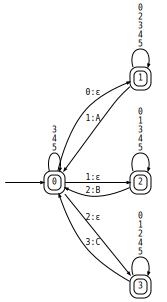

In [20]:
fst = fst_of['scaled_newspeak']
brief(fst, 'scaled_newspeak')
display(fst)

### layered_witnesses — *witness check at scale (level 2)*

Chain of gate/universal/partial layers. Despite combinatorial powerset
blowup, the witness check resolves every universality query in O(|S|).

layered_witnesses: 9 states, |A|=2, |B|=1
  all_input_universal=False, ip_universal=[1, 4, 7] (3/9), functional=True


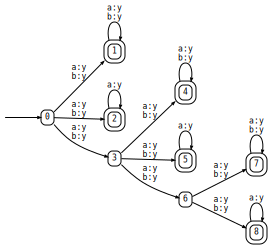


Rust stats across layer counts and target lengths:
  layers=3, tlen=5 (9 states, 3 ip-universal):
  DFA: 15 states, 22 arcs
  universality: 4 calls (4 T, 0 F), sub_bfs=0
  layers=5, tlen=10 (15 states, 5 ip-universal):
  DFA: 46 states, 80 arcs
  universality: 6 calls (6 T, 0 F), sub_bfs=0
  layers=10, tlen=15 (30 states, 10 ip-universal):
  DFA: 111 states, 200 arcs
  universality: 11 calls (11 T, 0 F), sub_bfs=0


In [21]:
fst = fst_of['layered_witnesses']
brief(fst, 'layered_witnesses')
display(fst)

if HAS_RUST:
    print('\nRust stats across layer counts and target lengths:')
    for n_layers, tlen in [(3, 5), (5, 10), (10, 15)]:
        fst_scaled = examples.layered_witnesses(n_layers=n_layers)
        ip = compute_ip_universal_states(fst_scaled)
        n = len(list(fst_scaled.states))
        print(f'  layers={n_layers}, tlen={tlen} ({n} states, {len(ip)} ip-universal):')
        rust_stats(fst_scaled, tuple('y' for _ in range(tlen)))

## Observations

**29 of 30 FSTs are (partial) functions.** Only `mystery6` is a genuine
relation. Functionality is required because peekaboo algorithms only agree
with Precover on functional transducers.

**6 FSTs are all-input-universal** (replace, delete_b, duplicate,
weird_copy, togglecase, lowercase). These trigger the `all_input_universal`
fast path, which skips powerset construction entirely.

**12 FSTs are not in any test file**: doom, infinite_quotient2,
togglecase, lowercase, mystery2, mystery6 are available as examples
but not exercised by the test suite.

**Test depth varies from 1 to 13**, chosen to balance coverage against
runtime — each level multiplies recursive calls by |B|.

**The 5 universality-filter FSTs** are the only tests specifically
designed to probe the optimization hierarchy. The other 13 in
`test_general.py` exercise universality incidentally.

**`number_comma_separator` is the only test with non-empty initial targets**,
testing that algorithms correctly resume from arbitrary target positions.